In [11]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta
from astropy import units
from numpy import random
plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rcParams['font.family']=['Palatino']
plt.rc('text', usetex=True)


import clmm.dataops as da
import clmm.theory as theory
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.utils import convert_units
from scipy.stats import chi2
from scipy.stats import kstest
import corner
import math

In [12]:
np.random.seed(0)

# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
    
cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
shapenoise    = 1.e-1 # True ellipticity standard variation

# Create galaxy catalog and Cluster object
data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)

gc.compute_tangential_and_cross_components(geometry="flat")
radius = convert_units(gc.galcat['theta'], 'radians', 'Mpc', redshift=gc.z, cosmo=cosmo)

# Create binning profile por binned methods
bin_edges = da.make_bins(0.7, 4, 50, method="evenlog10width")
profile = gc.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)

In [13]:
class KDELikelihood(Ncm.Data):

    len = GObject.Property(type=GObject.TYPE_UINT, default=0, flags=GObject.PARAM_READWRITE)
    dof = GObject.Property(type=GObject.TYPE_UINT, default=0, flags=GObject.PARAM_READWRITE)

    r_source  = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)
    z_source  = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)
    z_cluster = GObject.Property(type=float,      flags=GObject.PARAM_READWRITE)
    gt_source = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)
    et_source = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)
    true_var  = GObject.Property(type=float,      flags=GObject.PARAM_READWRITE)
    bw_gt     = GObject.Property(type=float,      flags=GObject.PARAM_READWRITE)


    def __init__(self, len=0):

        Ncm.Data.__init__(self)
        self.len = len
        self.dof = 2
        self.moo = clmm.Modeling()


    def init_from_data(self, r_source, z_source, z_cluster, et_source, true_var, moo):

        cut = [et > 0 and et < 0.1 for et in et_source]
        et_source_cut = [et_source[i] for i in range(len(et_source)) if cut[i]]
        r_source_cut  = [r_source[i] for i in range(len(et_source)) if cut[i]]
        z_source_cut  = [z_source[i] for i in range(len(et_source)) if cut[i]]

        assert len(et_source_cut) == len(r_source_cut)
        assert len(et_source_cut) == len(z_source_cut)


        self.props.r_source  = Ncm.Vector.new_array(r_source_cut)
        self.props.z_source  = Ncm.Vector.new_array(z_source_cut)
        self.props.z_cluster = z_cluster
        self.props.et_source = Ncm.Vector.new_array(et_source_cut)
        self.props.true_var  = true_var

        self.len = len(r_source_cut)
        self.moo = moo

        self.set_init(True)


    def do_get_length (self):

        return self.len


    def do_get_dof (self):

        return self.dof


    def do_begin(self):

        return


    def do_prepare(self, mset):

        self.dof = mset.fparams_len()
        self.moo.set_mset(mset)
        return


    def do_resample(self, mset, rng):
        # i'm not doing resample right now
        return


    def do_m2lnL_val(self, mset):

        gt_source = self.moo.eval_reduced_tangential_shear(self.props.r_source.dup_array(), self.props.z_cluster, self.props.z_source.dup_array())
        cut = [gt > 0 and gt < 0.1 for gt in gt_source]
        self.props.gt_source = Ncm.Vector.new_array([gt_source[i] for i in range(len(gt_source)) if cut[i]])
        
        iqr = np.subtract(*np.percentile(self.props.gt_source.dup_array(), [75, 25]))
        bw = 0.9 * min(np.std(self.props.gt_source.dup_array()), iqr/1.34) * self.len**(-1/5)

        likelihood_kde = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.FIXED, 1, 0.001)

        likelihood_kde.props.h_fixed = np.sqrt(bw**2 + self.props.true_var**2)

        for gt in self.props.gt_source.dup_array():
            if gt !=0:
                likelihood_kde.add_obs(gt)
        
        likelihood_kde.prepare()

        m2lnL = 0

        for et in self.props.et_source.dup_array():
            p = likelihood_kde.eval_p(et)
            if p != 0:
                m2lnL += np.log(likelihood_kde.eval_p(et))
        
        m2lnL *= -2 

        return m2lnL

GObject.type_register(KDELikelihood)

NcContext.KDELikelihood

In [14]:
moo = clmm.Modeling(massdef='mean', delta_mdef=200, halo_profile_model='nfw')
moo.set_cosmo(cosmo)

kde_likelihood_data = KDELikelihood()

kde_likelihood_data.init_from_data(r_source=radius, z_source=gc.galcat['z'], z_cluster=gc.z, et_source=gc.galcat['et'], true_var=shapenoise, moo=moo)

mset = kde_likelihood_data.moo.get_mset()

MDelta_pi = mset.param_get_by_full_name('NcHaloDensityProfile:log10MDelta')
cDelta_pi = mset.param_get_by_full_name('NcHaloDensityProfile:cDelta')

mset.param_set_ftype(MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset.param_set_ftype(cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset.prepare_fparam_map()

dset = Ncm.Dataset.new()
dset.append_data(kde_likelihood_data)
lh = Ncm.Likelihood.new(dset)

In [15]:
fit = Ncm.Fit.new(Ncm.FitType.NLOPT, 'ln-neldermead', lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

fit.run(Ncm.FitRunMsgs.SIMPLE)
fit.obs_fisher()
fit.log_info()
fit.log_covar()

mest = 10**mset.param_get(MDelta_pi.mid, MDelta_pi.pid)
print ("% 22.15e" % mest)

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#..............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:11.5071310
#  iteration            [000057]
#  function evaluations [000059]
#  gradient evaluations [000000]
#  degrees of freedom   [000000]
#  m2lnL     =    -16553.7148022187 (    -16553.715 )
#  Fit parameters:
#     4.3002468585968      15.3009742057165    
#----------------------------------------------------------------------------------
# Data used:
#   - NcContext+KDELikelihood-v2
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model par


(process:294542): NUMCOSMO-WARNING **: 19:02:51.695: ncm_fit_fisher_to_covar: covariance matrix not positive definite, errors are not trustworthy.


In [16]:
print ("% 22.15e" % mest)

 1.999743094298598e+15


In [17]:
Ncm.func_eval_set_max_threads(4)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0e-1)

nwalkers = 100
stretch = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new (fit, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_data_file("mass_fit_kde.fits")
esmcmc.set_auto_trim(True)
esmcmc.set_auto_trim_div(100)
esmcmc.set_max_runs_time(2.0*60.0)
esmcmc.set_nthreads(4)

esmcmc.start_run()
esmcmc.run(10000/nwalkers)
esmcmc.end_run()

mcat_wrong = esmcmc.peek_catalog()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      4
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensamble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0100.
#   Number of threads: 0004.
#   Using MPI:         no - use MPI enabled but no slaves available.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Skipping 10000 points (100.000000 iterations), will start at 10001-th point.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: validating catalog rows [9900, 10000)


: 

: 

In [ ]:
rr = np.logspace(-0.5, np.log10(5), 100)

gt_model  = moo.eval_reduced_tangential_shear (rr, gc.z, np.mean(gc.galcat['z']))
m_est     = 10**mset.param_get(MDelta_pi.mid, MDelta_pi.pid)
m_est_err = fit.covar_sd(MDelta_pi.mid, MDelta_pi.pid) * m_est * math.log(10.0)

print ("% 22.15e +/- %.0e" % (m_est, m_est_err))

 1.090518052763500e+15 +/- 2e+13


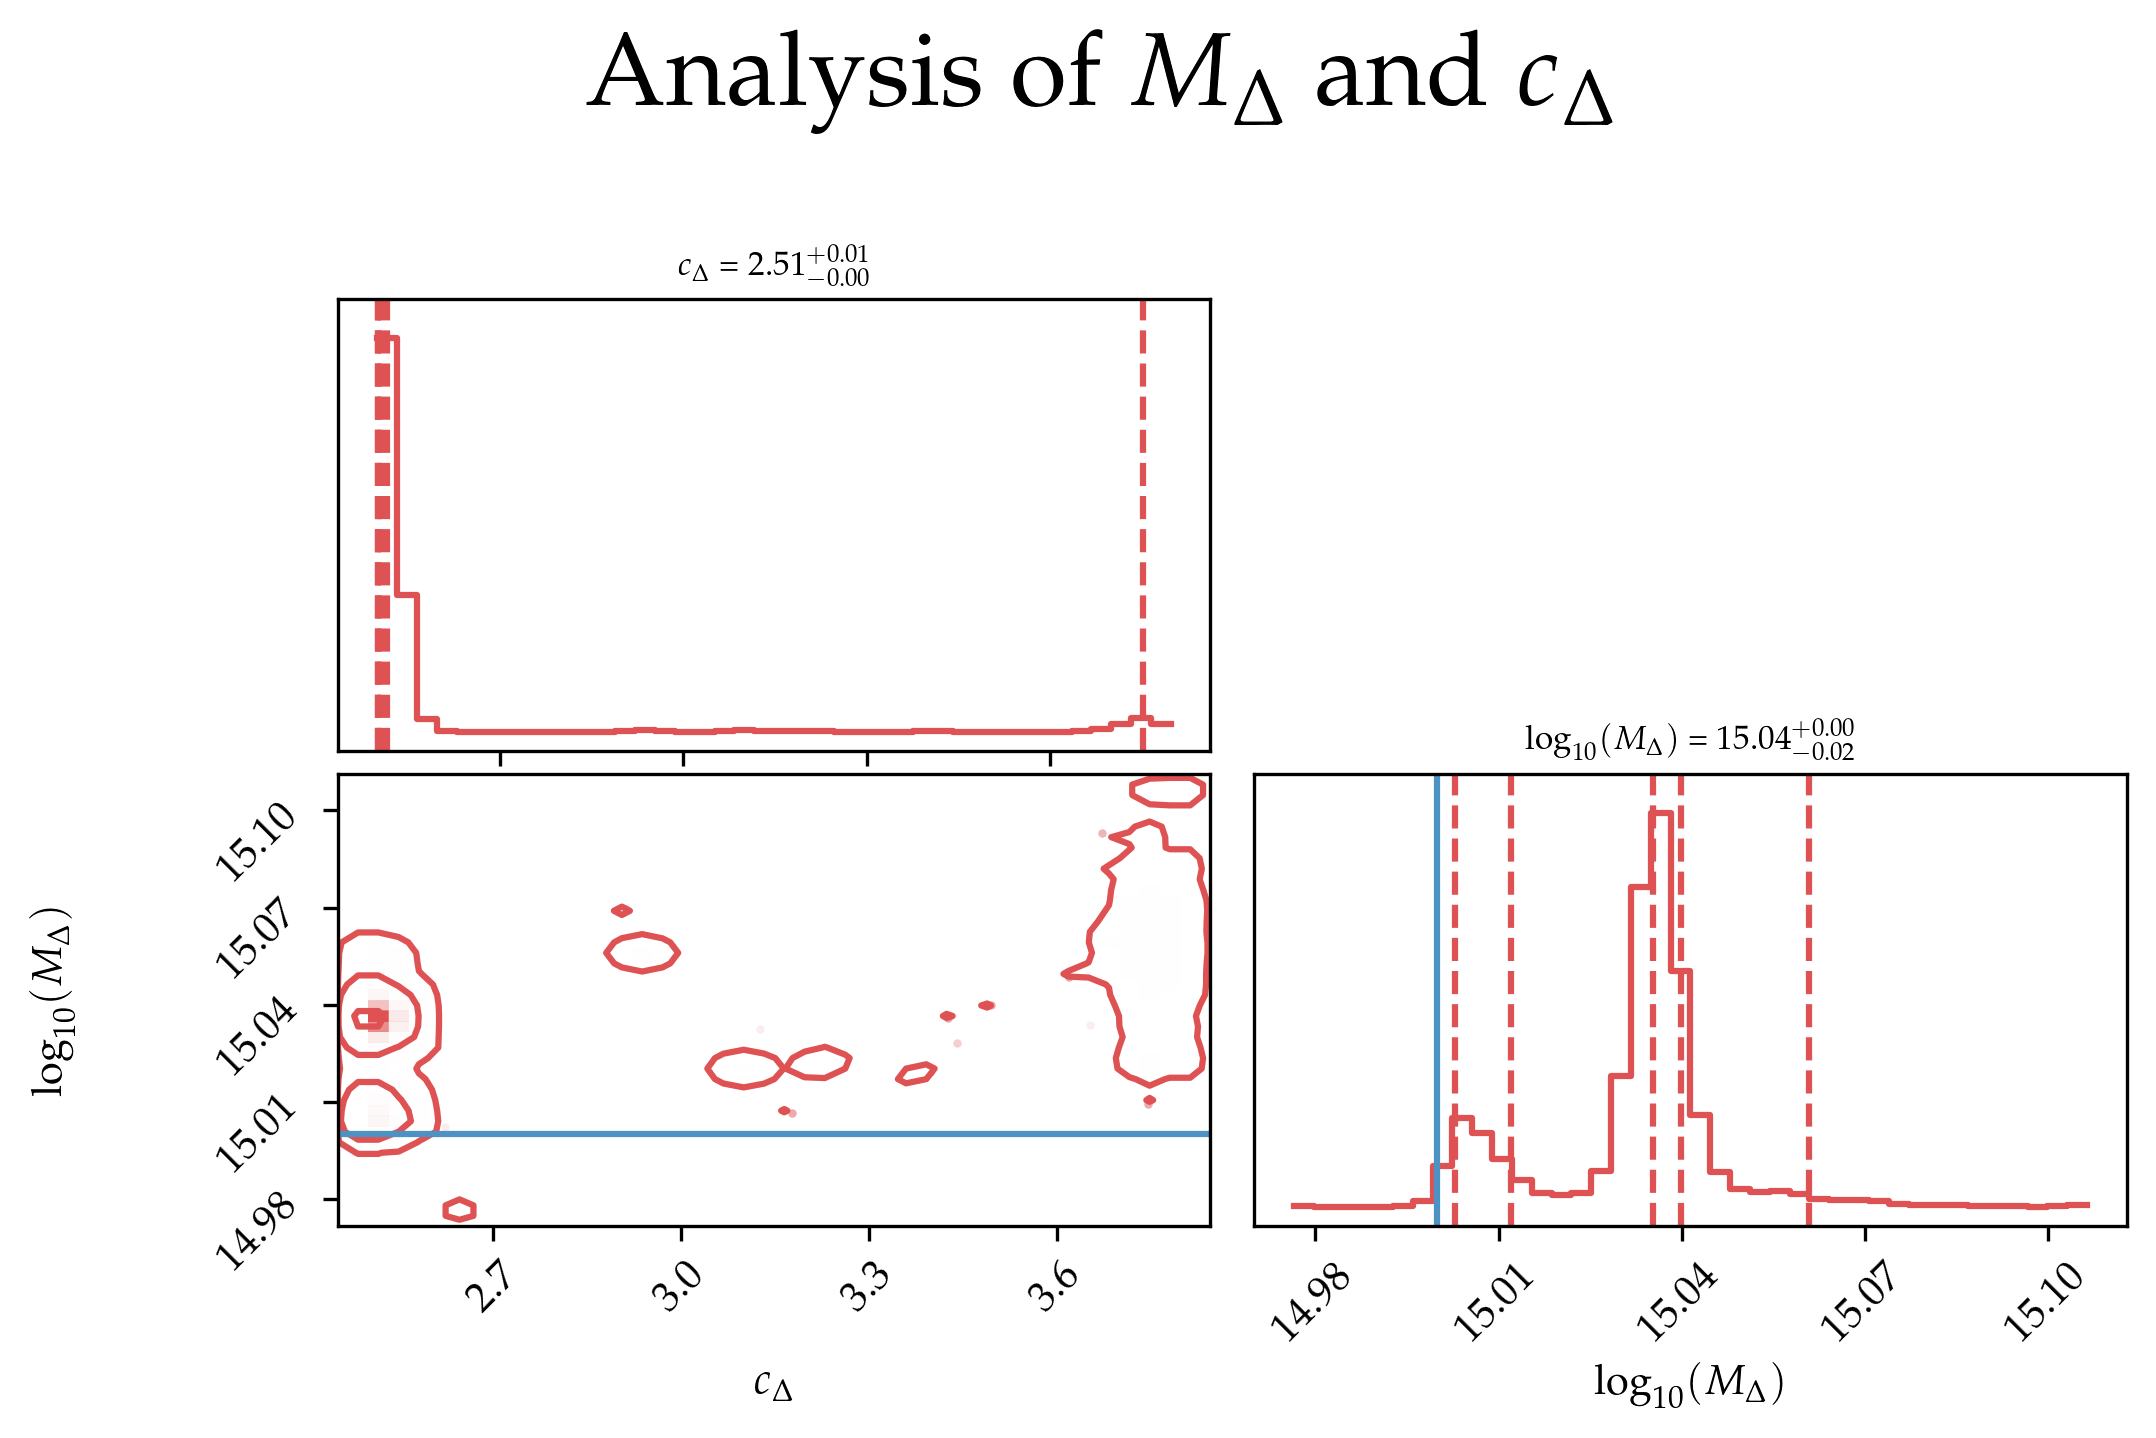

In [ ]:
s1d1 = chi2.cdf (1.0, df = 1)
s1d2 = chi2.cdf (4.0, df = 1)
s2d1 = chi2.cdf (1.0, df = 2)
s2d2 = chi2.cdf (4.0, df = 2)
s2d3 = chi2.cdf (9.0, df = 2)
qts = [0.5 - s1d2 / 2.0, 0.5 - s1d1 / 2.0, 0.5, 0.5 + s1d1 / 2.0, 0.5 + s1d2 / 2.0]

mcat = esmcmc.peek_catalog()
rows = np.array([mcat.peek_row(i).dup_array() for i in range(nwalkers * 10, mcat.len())])
params = ["$" + mcat.col_symb(i) + "$" for i in range (mcat.ncols())]

fig, ax = plt.subplots(2, 2, figsize=(8,5), dpi=300)

figure = corner.corner(rows[:,1:], labels=params[1:], reverse=False, quantiles=qts, levels=(s2d1, s2d2, s2d3), bins=40, smooth=0.8, smooth1d=0.8, color='#DE5253', show_titles=True, fig=fig, title_kwargs={"fontsize": 8}, label_kwargs={"fontsize": 10}, truths=[4,15], truth_color='#4C92C3', alpha=0.8)

fig.suptitle(f"Analysis of $M_\Delta$ and $c_\Delta$", fontsize=25)

# fig.tight_layout()
fig.subplots_adjust(top=0.8)

In [ ]:
class BinnedLikelihood(Ncm.DataGaussDiag):

    r_source   = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)
    z_source   = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)
    z_cluster  = GObject.Property(type=float,      flags=GObject.PARAM_READWRITE)
    gt_source  = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)
    et_source  = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)
    true_var   = GObject.Property(type=float,      flags=GObject.PARAM_READWRITE)
    source_bin = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)


    def __init__(self, len=0):

        Ncm.DataGaussDiag.__init__(self, n_points=0)
        self.moo = clmm.Modeling()


    def init_from_data(self, r_source, z_source, z_cluster, et_source, true_var, moo):

        self.props.r_source   = Ncm.Vector.new_array(r_source)
        self.props.z_source   = Ncm.Vector.new_array(z_source)
        self.props.z_cluster  = z_cluster
        self.props.et_source  = Ncm.Vector.new_array(et_source)
        self.props.true_var   = true_var

        self.props.source_bin = Ncm.Vector.new_array()

        self.len = len(r_source)
        self.moo = moo

        self.set_init(True)


    def do_get_length (self):

        return self.len


    def do_get_dof (self):

        return self.dof


    def do_begin(self):

        return


    def do_prepare(self, mset):

        self.dof = mset.fparams_len()
        self.moo.set_mset(mset)
        return


    def do_resample(self, mset, rng):
        # i'm not doing resample right now
        return


    def do_m2lnL_val(self, mset):
        
        

        return m2lnL

GObject.type_register(KDELikelihood)

NcContext.KDELikelihood